# Lag-Llama


### Installation
#### (1) Lag-Llama's dependency: GluoTS

In [ ]:
# Installation of gluonTS
!pip install --upgrade mxnet==1.6.0
!pip install gluonts==0.14.2
!pip uninstall numpy # Downgrade numpy to 1.23
!pip3 install mxnet-mkl==1.6.0 numpy==1.23.1


Found existing installation: numpy 1.25.2
Uninstalling numpy-1.25.2:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.10
    /usr/local/lib/python3.10/dist-packages/numpy-1.25.2.dist-info/*
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libgfortran-040039e1.so.5.0.0
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-5007b62f.3.23.dev.so
    /usr/local/lib/python3.10/dist-packages/numpy.libs/libquadmath-96973f99.so.0.0.0
    /usr/local/lib/python3.10/dist-packages/numpy/*
Proceed (Y/n)? y
  Successfully uninstalled numpy-1.25.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 79.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
chex 0.1.85 requires numpy>=1.24.1, but you have numpy 1.23

In [ ]:
!git clone https://github.com/time-series-foundation-models/lag-llama/

Cloning into 'lag-llama'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 136 (delta 46), reused 52 (delta 26), pack-reused 55
Receiving objects: 100% (136/136), 195.29 KiB | 8.49 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [ ]:
cd lag-llama

/content/lag-llama


In [ ]:
# !pip install -r requirements.txt --quiet # this could take some time
# Or pip install one by one of the libraries in requirements.txt so you can observe the progress
!pip install gluonts[torch]
!pip install torch>=2.0.0
!pip install wandb
!pip install scipy
!pip install pandas==2.1.4
!pip install huggingface_hub[cli]

In [ ]:
!huggingface-cli download time-series-foundation-models/Lag-Llama lag-llama.ckpt --local-dir /content/lag-llama

Consider using `hf_transfer` for faster downloads. This solution comes with some limitations. See https://huggingface.co/docs/huggingface_hub/hf_transfer for more details.
/content/lag-llama/lag-llama.ckpt


In [ ]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from lag_llama.gluon.estimator import LagLlamaEstimator

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path = '/content/gdrive/My Drive/data/time_series'
# https://www.kaggle.com/datasets/yasserh/walmart-dataset
data = pd.read_csv(path + '/walmart2.csv') # THe data have been downloaded and saved as 'walmart2.csv'
#data = pd.read_pickle(path + '/walmart2.pkl')
# convert string to datetime64
data["ds"] = pd.to_datetime(data["Date"],format='%d-%m-%Y')
#data = data.sort_values(by=['Store','ds'])
data.tail()

,Unnamed: 0,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,ds
6430,6423,45,10-08-2012,733037.32,0,78.65,3.722,191.162613,8.684,2012-08-10
6431,6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667,2012-10-19
6432,6434,45,26-10-2012,760281.43,0,58.85,3.882,192.308899,8.667,2012-10-26
6433,6410,45,11-05-2012,770487.37,0,61.24,3.889,190.976417,8.567,2012-05-11
6434,6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667,2012-10-12


In [ ]:
data.dtypes

Unnamed: 0               int64
Store                    int64
Date                    object
Weekly_Sales           float64
Holiday_Flag             int64
Temperature            float64
Fuel_Price             float64
CPI                    float64
Unemployment           float64
ds              datetime64[ns]
dtype: object

Text(0.5, 1.0, 'Walmart Weekly Sales of Store 1 - 10')

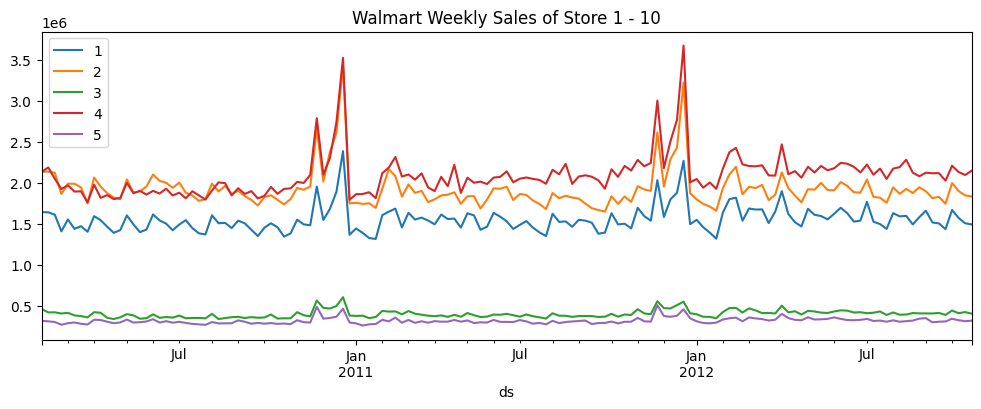

In [ ]:
# pivot the data into the correct shape
storewide = data.pivot(index='ds', columns='Store', values='Weekly_Sales')
some_stores = storewide.loc[:,1:10] # Plot only Store 1 - 10
storewide = some_stores. # Model only Store 1-10 in this demo
# plot the pivoted dataframe
some_stores.plot(figsize=(12, 4))
plt.legend(loc='upper left')
plt.title("Walmart Weekly Sales of Store 1 - 10")

In [ ]:
print("The time series has", storewide.shape[0], "weeks")

The time series has 143 weeks


In [ ]:
len_train = int(storewide.shape[0] * 0.85)
train_data = storewide[0:len_train]
test_data = storewide[len_train:]
[train_data.shape, test_data.shape]

[(121, 5), (22, 5)]

In [ ]:
# Prepare the data for deepAR format
from gluonts.dataset.common import ListDataset
from gluonts.dataset.field_names import FieldName

def to_deepar_format(dataframe, freq):
    start_index = dataframe.index.min()
    data = [{
                FieldName.START:  start_index,
                FieldName.TARGET:  dataframe[c].values,
            }
            for c in dataframe.columns]
    print(data[0])
    return ListDataset(data, freq=freq)
train_data_lds = to_deepar_format(train_data, 'W')
test_data_lds = to_deepar_format(test_data, 'W')

{'start': Timestamp('2010-02-05 00:00:00'), 'target': array([1643690.9 , 1641957.44, 1611968.17, 1409727.59, 1554806.68,
       1439541.59, 1472515.79, 1404429.92, 1594968.28, 1545418.53,
       1466058.28, 1391256.12, 1425100.71, 1603955.12, 1494251.5 ,
       1399662.07, 1432069.95, 1615524.71, 1542561.09, 1503284.06,
       1422711.6 , 1492418.14, 1546074.18, 1448938.92, 1385065.2 ,
       1371986.6 , 1605491.78, 1508237.76, 1513080.49, 1449142.92,
       1540163.53, 1507460.69, 1430378.67, 1351791.03, 1453329.5 ,
       1508239.93, 1459409.1 , 1345454.  , 1384209.22, 1551659.28,
       1494479.49, 1483784.18, 1955624.11, 1548033.78, 1682614.26,
       1891034.93, 2387950.2 , 1367320.01, 1444732.28, 1391013.96,
       1327405.42, 1316899.31, 1606629.58, 1649614.93, 1686842.78,
       1456800.28, 1636263.41, 1553191.63, 1576818.06, 1541102.38,
       1495064.75, 1614259.35, 1559889.  , 1564819.81, 1455090.69,
       1629391.28, 1604775.58, 1428218.27, 1466046.67, 1635078.41,
       1

## Lag-Llama

In [ ]:
context_length = len(train_data)
prediction_length = len(test_data)

In [ ]:
ckpt = torch.load("lag-llama.ckpt", map_location=torch.device('cuda:0'))
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

In [ ]:
estimator = LagLlamaEstimator(
    ckpt_path="lag-llama.ckpt",
    prediction_length=prediction_length,
    context_length=context_length,

    # estimator args
    input_size=estimator_args["input_size"],
    n_layer=estimator_args["n_layer"],
    n_embd_per_head=estimator_args["n_embd_per_head"],
    n_head=estimator_args["n_head"],
    scaling=estimator_args["scaling"],
    time_feat=estimator_args["time_feat"],
)

lightning_module = estimator.create_lightning_module()
transformation = estimator.create_transformation()
predictor = estimator.create_predictor(transformation, lightning_module)

In [ ]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=train_data_lds,
    predictor=predictor,
)

In [ ]:
forecasts = list(forecast_it)
tss = list(ts_it)

In [ ]:
evaluator = Evaluator()

In [ ]:
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts))

Running evaluation: 5it [00:00, 155.99it/s]


In [ ]:
print("CRPS:", agg_metrics['mean_wQuantileLoss'])

CRPS: 0.07203626685077341


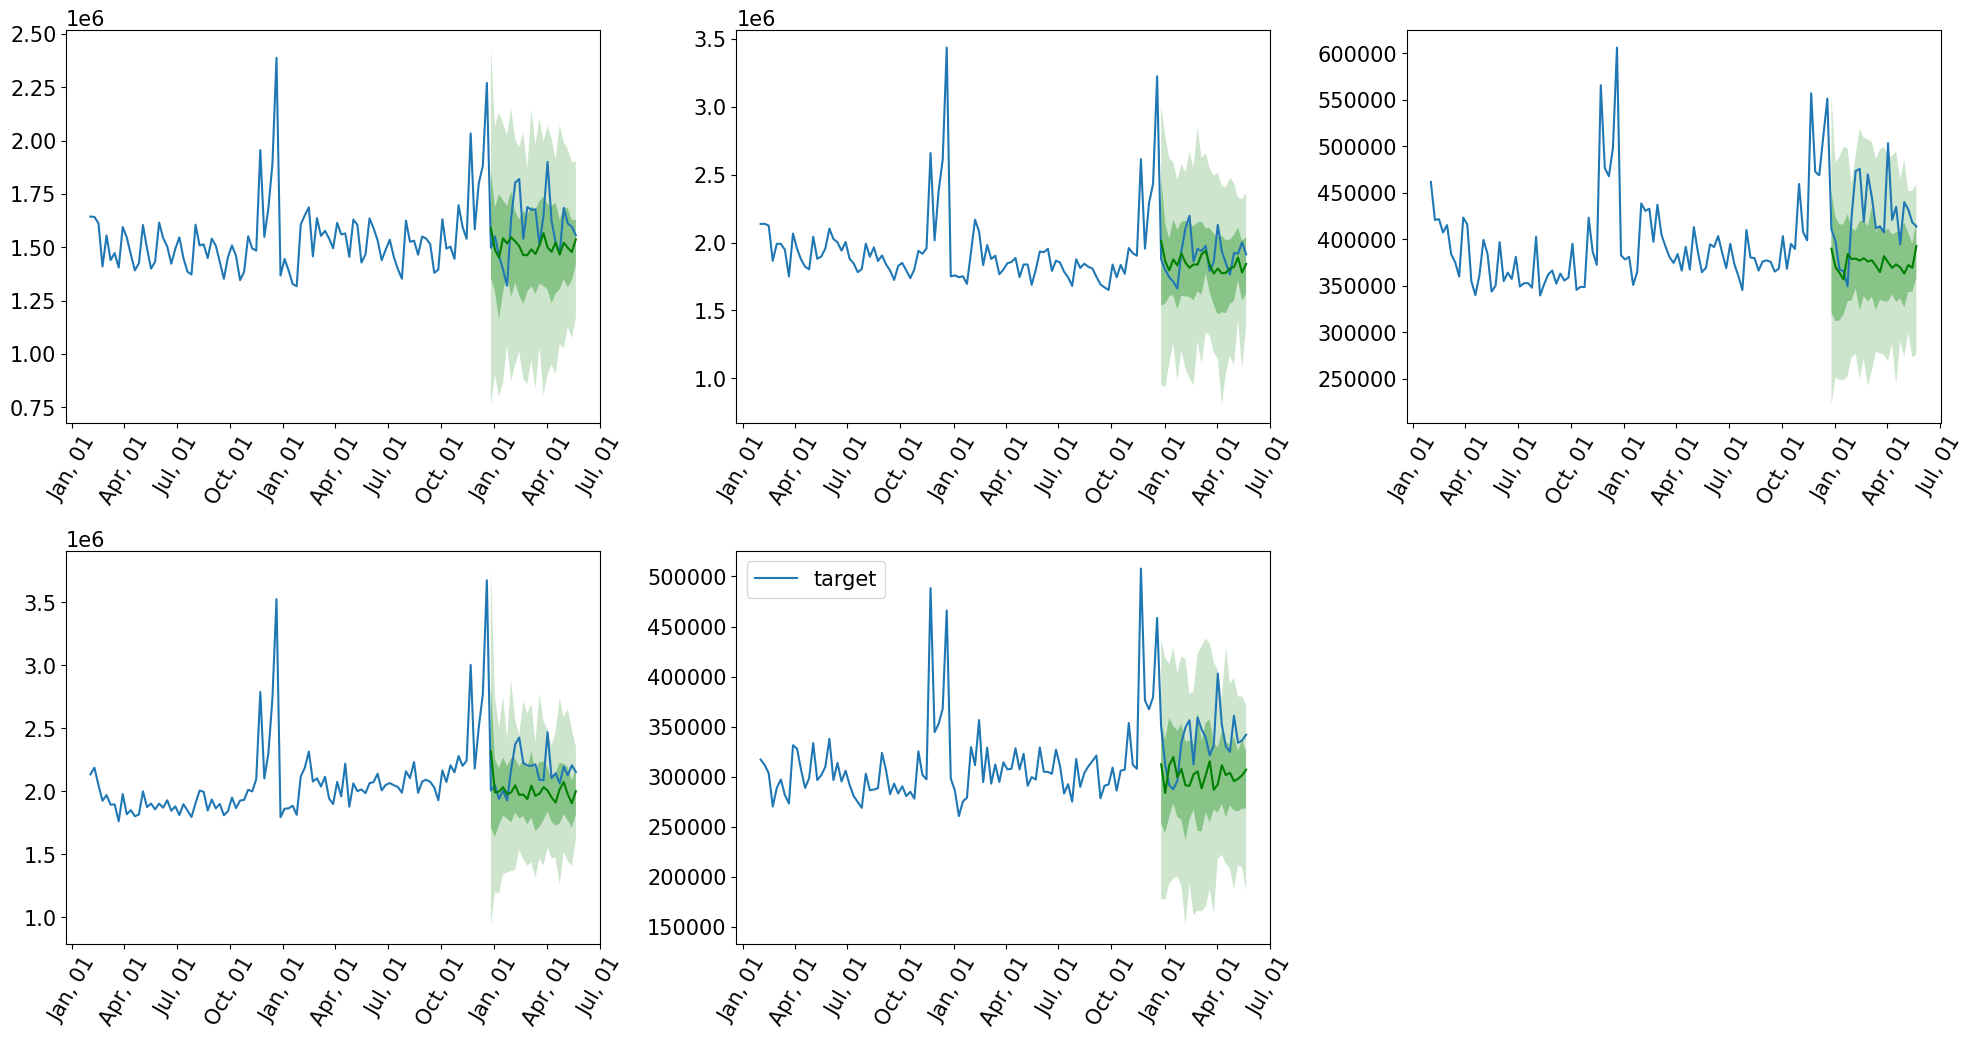

In [ ]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 9):
    ax = plt.subplot(3, 3, idx+1)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target", )
    forecast.plot( color='g')
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()